## Time series plots with aggregate uncertainty

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
from world_econ import *

First let's simulate the economy with $\theta > 0$

In [4]:
alpha = 0.48
z = 1.0
q1 = 0.8
q0 = 0.2
v1 = 4

cx = Country(v1=v1, z=z, q1=q1, q0=q0, alpha=alpha)
cy = Country(v1=v1, z=z, q1=q1, q0=q0, alpha=alpha)

In [5]:
cx.stability_measure

-2.9328588984725346

In [6]:
cx.calibrate(verbose=True)

should be < 1: 0.46718246885011916


In [7]:
cx.theta

164.75451853949073

In [8]:
cx.v1

4

In [9]:
(2 * cx.alpha - 1) * cx.theta * cx.wstar / (1 - cx.alpha)

-2.9328588984725346

In [10]:
ts_length = 28

# Insert some shocks
shocks = np.ones(ts_length)
shocks[1] = 1.1
shocks[2] = 1/1.1

shocks[14] = 0.9
shocks[15] = 1/0.9

In [11]:
cx.wstar

0.23141802736660025

Simulation with moral hazard...

In [12]:
# Set up storage
yx = []
yy = []

# Initial conditions, wages in each country
x, y = cx.wstar, cy.wstar   

# Simulate to smooth things out
for i in range(10):
    r = integrated_world_r(cx, x, cy, y)
    x = cx.update_wage(x, r)
    y = cy.update_wage(y, r)

In [13]:
x, y

(0.23141802736660011, 0.23141802736660011)

In [14]:
# Simulate
for i in range(ts_length):

    yx.append(x / (1 - alpha))
    yy.append(y / (1 - alpha))

    # Get interest rate for world econ
    r = integrated_world_r(cx, x, cy, y)

    # Adjust shock
    cx.z = cx.z * shocks[i]
    cx.calibrate()
    
    # Update wages
    x = cx.update_wage(x, r)
    y = cy.update_wage(y, r)


yy = np.asarray(yy)
yx = np.asarray(yx)

yy = yy / yy[0]
yx = yx / yx[0]

In [15]:
x, y

(0.23482889963357223, 0.22786805190321807)

Now let's simulate with the same shocks but $\theta  = 0$.

In [16]:
cx.v1 = 0
cy.v1 = 0
cx.calibrate()
cy.calibrate()

theta, R = cx.theta, cx.R
wstar = cx.wstar

# Set up storage
yxn = []
yyn = []


# Initial conditions, wages in each country
x, y = cx.wstar, cy.wstar   

# Simulate to smooth things out
for i in range(10):
    r = alpha * R**alpha * (2/ (x + y))**(1 - alpha)
    #r = integrated_world_r(cx, x, cy, y)
    x = cx.update_wage(x, r)
    y = cy.update_wage(y, r)

    
# Simulate
for i in range(ts_length):

    yxn.append(x / (1 - alpha))
    yyn.append(y / (1 - alpha))

    # Get interest rate for world econ
    r = alpha * (R**alpha) * (2/ (x + y))**(1 - alpha)
    #r = integrated_world_r(cx, x, cy, y)

    # Adjust shock
    cx.z = cx.z * shocks[i]
    cx.calibrate()
    
    # Update wages
    x = cx.update_wage(x, r)
    y = cy.update_wage(y, r)


yyn = np.asarray(yyn)
yxn = np.asarray(yxn)

yyn = yyn / yyn[0]
yxn = yxn / yxn[0]

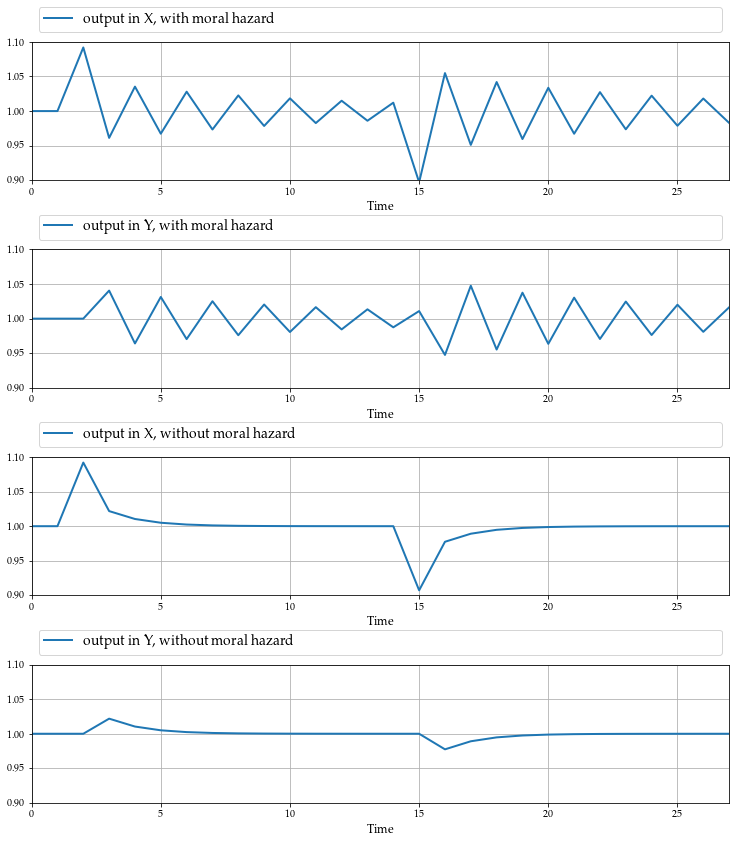

In [17]:
n_rows = 4
fig, axes = plt.subplots(n_rows, 1, figsize=(12.5, 14))

bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor' : bbox, 'loc' : 3, 'mode' : 'expand', 'fontsize' : 14}
p_args = {'lw' : 2, 'alpha' : 0.7}

plt.subplots_adjust(hspace=0.5)

for ax in axes:
    ax.grid()
    ax.set_xlabel(r'Time', fontsize=12)
    ax.set_xlim(0, ts_length-1)
    ax.set_ylim(0.9, 1.1)
    #ax.set_yticks((0.9, 1.0, 1.1))


idx = range(ts_length)

ax = axes[0]
ax.plot(idx, yx, lw=2, label='output in X, with moral hazard')
ax.legend(ncol=1, **legend_args)

ax = axes[1]
ax.plot(idx, yy, lw=2, label='output in Y, with moral hazard')
ax.legend(ncol=1, **legend_args)


ax = axes[2]
ax.plot(idx, yxn, lw=2, label='output in X, without moral hazard')
ax.legend(ncol=1, **legend_args)

ax = axes[3]
ax.plot(idx, yyn, lw=2, label='output in Y, without moral hazard')
ax.legend(ncol=1, **legend_args)

plt.savefig("foo.pdf")
plt.show()